In [0]:
import glob
import torch
from PIL import Image
import torch.nn as nn
import torch
from torchvision import transforms
import torch.nn.functional as F
from torch.optim import SGD
import torchvision.datasets as datasets
from torch.autograd import Variable

In [0]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

In [3]:
from google.colab import drive
drive.mount('/content/drive')
data = datasets.ImageFolder("/content/drive/My Drive/DeepLearning/test_data", transform = transform)
train_size = int(0.75 * len(data))
test_size = len(data) - train_size
train_set, test_set = torch.utils.data.random_split(data, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)
print(len(data),len(train_set),len(test_set),train_size,test_size)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
2546 1909 637 1909 637


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


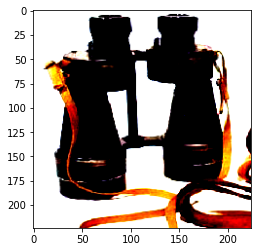

In [4]:
import torchvision
img=iter(train_loader).next()[0][0]
import matplotlib.pyplot as plt
# img =torchvision.transforms.ToPILImage()(img)
# from PIL import Image
print(img.shape)
plt.imshow(img.permute(1,2,0))
plt.show() #200x300

In [0]:
class VGG(nn.Module):
    def __init__(self,n_classes):
        super(VGG,self).__init__()
                                #(in_channel_size,out_channel_Size,kernel_size,padding)
        self.conv1_1 = nn.Conv2d(3,32,kernel_size=3,padding=1)
        self.conv1_2 = nn.Conv2d(32,32,kernel_size=3,padding=1)
        
        self.conv2_1 = nn.Conv2d(32,64,kernel_size=3,padding=1)
        self.conv2_2 = nn.Conv2d(64,64,kernel_size=3,padding=1)
        
        self.conv3_1 = nn.Conv2d(64,128,kernel_size=3,padding=1)
        self.conv3_2 = nn.Conv2d(128,128,kernel_size=3,padding=1)
        # self.conv3_3 = nn.Conv2d(256,256,kernel_size=3,padding=1)
        
        # self.conv4_1 = nn.Conv2d(128,256,kernel_size=3,padding=1)
        # self.conv4_2 = nn.Conv2d(256,256,kernel_size=3,padding=1)
        # self.conv4_3 = nn.Conv2d(512,512,kernel_size=3,padding=1)
        
        # self.conv5_1 = nn.Conv2d(512,512,kernel_size=3,padding=1)
        # self.conv5_2 = nn.Conv2d(512,512,kernel_size=3,padding=1)
        # self.conv5_3 = nn.Conv2d(512,512,kernel_size=3,padding=1)
                                    #(kerel_size,stride)
        self.maxpool = nn.MaxPool2d(2,2)
        
        self.fc6 = nn.Linear(28*28*128,512)
        self.fc7 = nn.Linear(512,102)
        # self.fc8 = nn.Linear(512,102)
        
    def forward(self,x,training=True):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        # x = F.relu(self.conv3_3(x))
        x = self.maxpool(x)
        # x = F.relu(self.conv4_1(x))
        # x = F.relu(self.conv4_2(x))
        # x = F.relu(self.conv4_3(x))
        # x = self.maxpool(x)
        # x = F.relu(self.conv5_1(x))
        # x = F.relu(self.conv5_2(x))
        # x = F.relu(self.conv5_3(x))
        # x = self.maxpool(x)
        x = x.view(-1,28*28*128)
        x = F.relu(self.fc6(x))
        x = F.dropout(x,0.5,training=training)
        x = F.relu(self.fc7(x))
        # x = F.dropout(x,0.5,training=training)
        # x = F.relu(self.fc8(x))
        # x = F.softmax(x,dim=1)
        return x
    def predict(self,x):
        x = F.softmax(self.forward(x,training=False),dim=1)
        return x
    # def accuracy(self,x,y):
    #     prediction = self.predict(x)
    #     maxv, index = torch.max(prediction,1)
    #     acc = 100 * torch.sum(torch.eq(indices.float(), y.float()).float())/y.size()[0]
    #     return acc.cpu().data[0]
vgg16 = VGG(102)


In [9]:
optimizer = torch.optim.Adam(vgg16.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
cuda_avail = torch.cuda.is_available()
if cuda_avail:
    print("running on GPU")
    vgg16.cuda('cuda:0')
def adjust_learning_rate(epoch):
    lr = 0.01

    if epoch > 100:
        lr = lr / 1000000
    elif epoch > 50:
        lr = lr / 100000
    elif epoch > 40:
        lr = lr / 10000
    elif epoch > 30:
        lr = lr / 1000
    elif epoch > 20:
        lr = lr / 100
    elif epoch > 10:
        lr = lr / 10
    elif epoch > 5:
        lr = lr / 10

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
        
        
def save_models(epoch):
    torch.save(vgg16.state_dict(), "vgg16model_{}.model".format(epoch))
    print("Chekcpoint saved")
    
    
def test():
    vgg16.eval()
    test_acc = 0.0
    for i, (images, labels) in enumerate(test_loader):

        if cuda_avail:
            images = Variable(images.cuda('cuda:0'))
            labels = Variable(labels.cuda('cuda:0'))

        # Predict classes using images from the test set
        outputs = vgg16(images)
        _, prediction = torch.max(outputs.data, 1)
        test_acc += torch.sum(prediction == labels.data)

    # Compute the average acc and loss over all 10000 test images
    test_acc = test_acc / test_size
    return test_acc

running on GPU


In [0]:
def train(num_epochs):
    best_acc = 0.0

    for epoch in range(num_epochs):
        vgg16.train()
        train_acc = 0.0
        train_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            # Move images and labels to gpu if available
            # if i>10:
            #   break
            if cuda_avail:
                images = Variable(images.cuda('cuda:0'))
                labels = Variable(labels.cuda('cuda:0'))

            # Clear all accumulated gradients
            optimizer.zero_grad()
            # Predict classes using images from the test set
            outputs = vgg16(images)
            # Compute the loss based on the predictions and actual labels
            # print(images.shape,outputs.shape,labels.shape)
            loss = loss_fn(outputs, labels)
            # Backpropagate the loss
            loss.backward()

            # Adjust parameters according to the computed gradients
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, prediction = torch.max(outputs.data, 1)
            
            train_acc += torch.sum(prediction == labels.data)

        # Call the learning rate adjustment function
        #adjust_learning_rate(epoch)

        # Compute the average acc and loss over all 50000 training images
        train_acc = train_acc / train_size
        train_loss = train_loss / train_size

        # Evaluate on the test set
        test_acc = test()

        # Save the model if the test acc is greater than our current best
        if test_acc > best_acc:
            save_models(epoch)
            best_acc = test_acc

        # Print the metrics
        print("Epoch {}, Train Accuracy: {} , TrainLoss: {} , Test Accuracy: {} ".format(epoch, train_acc, train_loss,test_acc))

In [0]:
train(20)

Chekcpoint saved
Epoch 0, Train Accuracy: 0.40806707739830017 , TrainLoss: 2.9058983600720367 , Test Accuracy: 0.4175824224948883 


In [0]:
# save_models(50)

In [0]:
PATH = "vgg16model_50.model"
model = VGG(102)
model.load_state_dict(torch.load(PATH))
cuda_avail = torch.cuda.is_available()
if cuda_avail:
    print("running on GPU")
    model.cuda('cuda:0')
model.eval()
test_acc = 0.0
for i, (images, labels) in enumerate(test_loader):

    if cuda_avail:
        images = Variable(images.cuda('cuda:0'))
        labels = Variable(labels.cuda('cuda:0'))

    # Predict classes using images from the test set
    outputs = model(images)
    _, prediction = torch.max(outputs.data, 1)
    
    test_acc += torch.sum(prediction == labels.data)

# Compute the average acc and loss over all 10000 test images
test_acc = test_acc / test_size
print(test_acc.cpu().numpy())
